# Predicting Bank Telemarketing Campaign Success Using Machine Learning

## Objective

The objective of this project is to predict whether a client will subscribe to a term deposit (yes or no) during a bank telemarketing campaign using machine learning models. This analysis will help banks target the right customers, reducing costs and improving efficiency.

## Table of Contents

1. Objective
2. Required Libraries
3. Introduction
4. Workflow Overview
5. Data Understanding
6. Exploratory Data Analysis (EDA)
7. Feature Engineering and Data Preprocessing
8. Model Building and Evaluation
9. Comparison of Models
10. Insights and Recommendations
11. Acknowledgments

## 2. Required Libraries

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import IterativeImputer  # Iterative Imputer is experimental
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder, StandardScaler, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# Model Selection and Evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score, make_scorer
)

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb

# Gradient Boosting Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Utility Libraries
from collections import Counter
import warnings

# Suppress Warnings
warnings.filterwarnings("ignore")

## 3. Introduction

Telemarketing is a key marketing strategy for banks to promote term deposits. However, targeting uninterested clients leads to wasted resources. Machine learning offers a powerful solution to predict customer behavior and improve campaign efficiency.

Dataset:

* The dataset contains information about clients, previous interactions, and the outcome (yes or no) of the telemarketing campaign.

Business Impact:

* This solution can significantly reduce costs by focusing on clients more likely to subscribe, thus improving the return on investment (ROI) for campaigns.

## 4. Workflow Overview

Below is the workflow followed in this notebook:

1. Data Loading and Understanding
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Data Preprocessing
5. Model Training (Random Forest, XGBoost, LightGBM, Gradient Boosting)
6. Model Evaluation and Comparison
7. Insights and Recommendations

## 5. Data Understanding

### Loading the Dataset

In [2]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

### Dataset Overview

In [3]:
# Overview of the data
print(train_df.shape)
print(test_df.shape)
train_df.head()

(39211, 16)
(10000, 15)


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
train_df.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

In [5]:
# Identify categorical and numerical columns
cat_cols = train_df.select_dtypes(include=['object']).columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
print('Cat cols:', cat_cols)
print('Num cols:', num_cols)

Cat cols: Index(['last contact date', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'poutcome', 'target'],
      dtype='object')
Num cols: Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [6]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

**Columns:**

- Clients with a history of credit **default** may be less likely to subscribe to a term deposit.
- (A credit card default occurs when a cardholder fails to pay their debt for an extended period, typically 180 days)
- (A term deposit is a type of deposit account held at a financial institution where money is locked up for some set period of time.
Term deposits are usually short-term deposits with maturities ranging from one month to a few years.
Typically, term deposits offer higher interest rates than traditional liquid savings accounts, whereby customers can withdraw their money at any time

- **balance:** The average yearly balance (in euros) of the client’s account.
Values: Numeric values (can be negative, indicating a debt).
Relevance: The financial stability of the client, reflected by the account balance, can influence their decision to subscribe to a term deposit.

- **housing:** Whether the client has a housing loan or not. Clients with a housing loan might be more financially constrained, affecting their likelihood of subscribing to additional products.

- **loan:** Whether the client has a personal loan or not. Like the housing loan, a personal loan could impact the client’s financial decision-making and willingness to invest in a term deposit.

- **duration:** The duration (in seconds) of the last contact with the client.
- (This feature is highly correlated with the target outcome. A longer conversation might indicate a more engaged client, but this feature is tricky since it’s only available after the contact is made.)

- **campaign:** The number of contacts performed during this campaign for this client (including the current contact).
- (If a client needs to be contacted multiple times, it might reflect either persistence or a lack of interest. The more the number of contacts, the less likely they might be to subscribe (due to annoyance).)

- **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted).
- (If a client was contacted recently, it might influence their response in the current campaign.)

- **previous:** The number of contacts made before this campaign to the client.
- (The history of prior contacts can indicate client familiarity or annoyance, which could affect the likelihood of subscribing.)

- **poutcome:** The outcome of the previous marketing campaign for this client.
- (Values:
"success": The client subscribed in the previous campaign.
"failure": The client did not subscribe in the previous campaign.
"other": Other outcomes.
"unknown": No information on the previous outcome.)
- (If a client previously subscribed successfully, they might be more inclined to subscribe again. Conversely, a failure could indicate a lack of interest.)s")

- **target:** The target variable, indicating whether the client subscribed to a term deposit or not..)

**Preferred values:**

1. **default**: `"no"`  
   Clients with no credit default are preferred.

2. **balance**: **Higher values**  
   A higher account balance indicates financial stability.

3. **housing**: `"no"`  
   Clients without a housing loan are more likely to subscribe.

4. **loan**: `"no"`  
   Clients without a personal loan are preferred, as they have fewer financial obligations.

5. **contact**: `"cellular"`  
   Cellular phone contacts are more effective for conversions.

6. **duration**: **Longer durations**  
   Longer call durations usually indicate client engagement and are preferred.

7. **campaign**: **Lower values** (e.g., 1-2 contacts)  
   Fewer contacts suggest early positive engagement.    

8. **pdays**: `-1` (never contacted before) or **lower values** 
   Either no prior contact or recent contact is preferred.    

9. **previous**: 1-2 prior contacts  
   A small number of previous contacts may show familiarity without overwhelming the client.

10. **poutcome**: `"success"`  
    Clients who had a successful outcome in a previous campaign are more likely to subscribe again.

## 6. Exploratory Data Analysis (EDA)

In [7]:
# Display basic info
print("\nTrain Data Info:")
train_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10

In [8]:
# Get statistics of numeric columns
print("\nStatistics for Numeric Columns:")
print(train_df.describe())

# Get statistics of categorical columns
print("\nStatistics for Categorical Columns:")
print(train_df.describe(include=['object']))


Statistics for Numeric Columns:
                age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  39211.000000  
mean      11.826171  
std       44.140259  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  

Statistics for Categorical Columns:
       last

In [9]:
# Getting unique values in categorical columns
# Loop through each column in cat_cols and print unique values
print('Unique values in ')
print("\n") 
for col in cat_cols:
    unique_values = train_df[col].unique()
    print(f"'{col}': {unique_values}")

Unique values in 


'job': ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]
'marital': ['married' 'single' 'divorced']
'education': ['secondary' 'tertiary' 'primary' nan]
'default': ['no' 'yes']
'housing': ['yes' 'no']
'loan': ['no' 'yes']
'contact': ['cellular' 'telephone' nan]
'poutcome': ['other' nan 'failure' 'success']


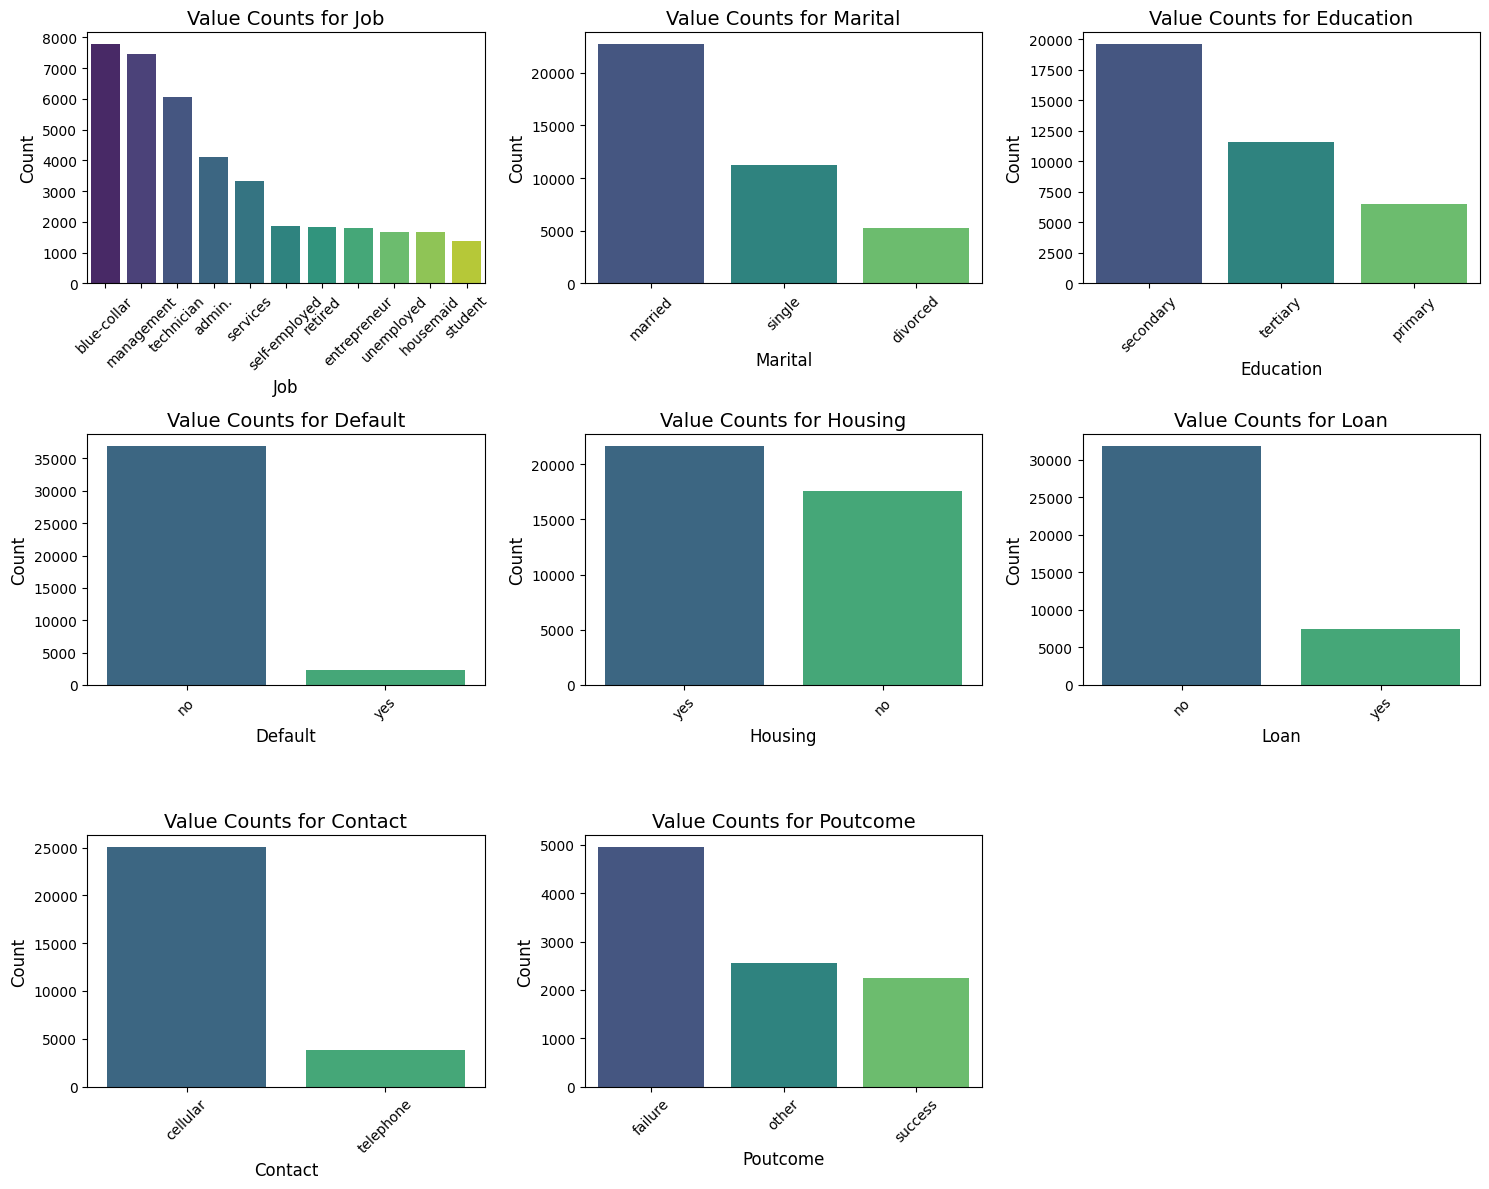

In [10]:
# Bar charts for value counts of categorical columns

plt.figure(figsize=(15, 12))

# Loop through the categorical columns and create subplots
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)  
    value_counts = train_df[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    
    # Set title and labels
    plt.title(f'Value Counts for {col.capitalize()}', fontsize=14)
    plt.xlabel(f'{col.capitalize()}', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# Get features having null values
[features for features in train_df.columns if train_df[features].isnull().sum()>0]

['job', 'education', 'contact', 'poutcome']

In [12]:
train_df.isnull().sum()  # total data (39211, 16)

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

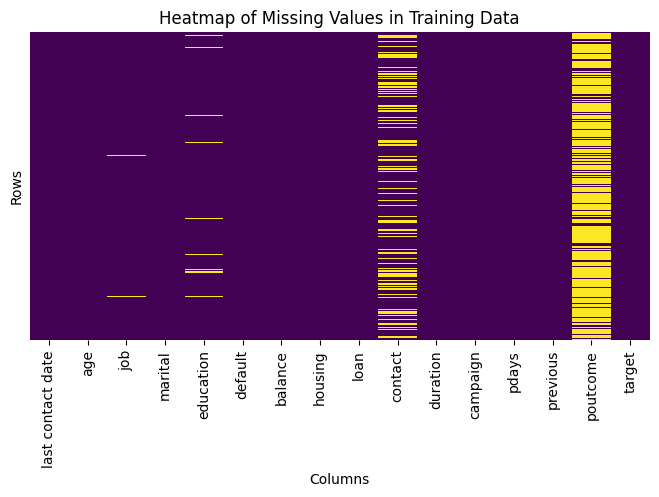

In [13]:
# Heatmap to visualize missing data in train_df
plt.figure(figsize=(8, 4))
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of Missing Values in Training Data')

# Show the plot
plt.show()

**Insights:** Data has missing values in certain categorical columns.

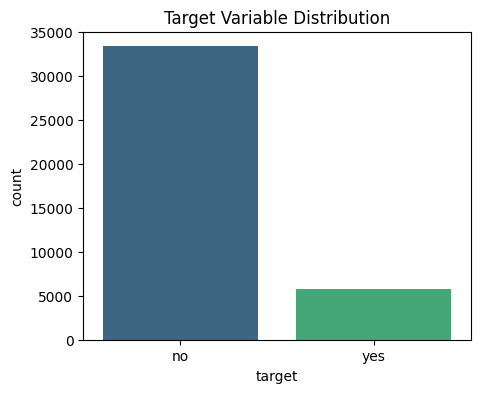

In [14]:
# Target variable distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=train_df, x='target', palette='viridis')
plt.title('Target Variable Distribution')
plt.show()

**Insights:** The target variable is imbalanced, with more clients not subscribing (no).

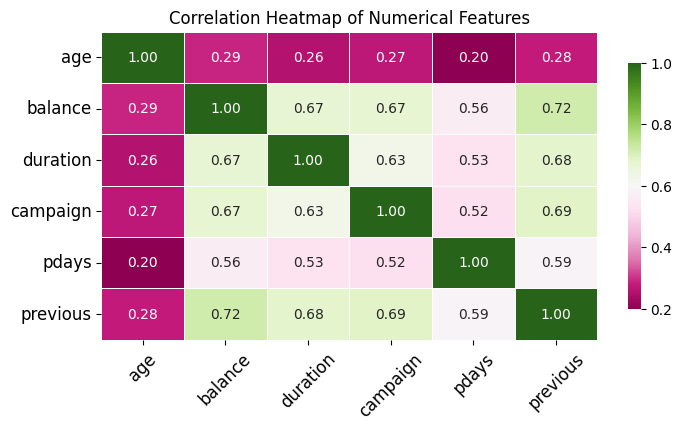

In [15]:
# Correlation heatmap of numerical features
# Compute correlation matrix
correlation_matrix = train_df[num_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 4))

# Create a heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,                # Show correlation values
    fmt=".2f",                 # Format correlation values to 2 decimal places
    cmap="PiYG",           # Colormap
    linewidths=0.5,            # Add grid lines for better readability
    cbar_kws={'shrink': 0.8}   # Adjust color bar size
)

# Add a title
plt.title("Correlation Heatmap of Numerical Features")

# Adjust tick labels for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

**Insights:**
* `balance` and `previous` have a strong positive correlation (0.72), suggesting a relationship between the account balance and the number of previous contacts.
* `balance` and `duration` (0.67), `campaign` and `duration` (0.63), and `previous` with `campaign` (0.69) indicate moderately strong relationships. These correlations suggest that account balances or prior contacts may affect durations and campaign numbers.
* `age` has low correlations with all other features (all below 0.3), indicating that age might not be strongly related to other numerical features. Determining whether it is informative for the target variable would help.
* High correlations between `balance`, `duration`, `campaign`, and `previous` might indicate some redundancy. Dimensionality reduction (like PCA) or careful feature selection may help reduce overfitting in models.

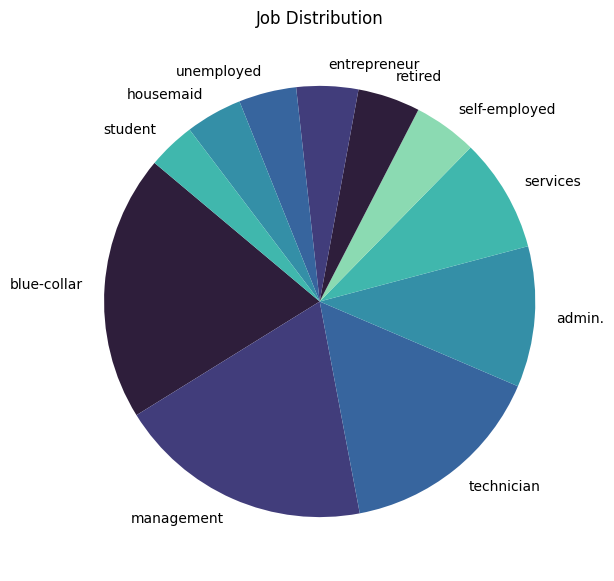

In [16]:
# Job distribution
job_names=train_df.job.value_counts().index
job_vals=train_df.job.value_counts().values

colors = sns.color_palette("mako")

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(job_vals, labels=job_names, colors=colors, startangle=140)

# Set title
plt.title("Job Distribution")

# Show the plot
plt.show()

**Insights:**
* `blue-collar`, `management`, and `technician` jobs constitute the largest segments, indicating these job types are prevalent in the dataset.
* Categories such as `housemaid`, `student`, and `unemployed` represent smaller portions of the population, suggesting underrepresentation in these groups. These may need careful handling during modeling to avoid overfitting or underrepresentation.
* Other categories, like `services` and `admin`, have moderate representation, balancing dominance and rarity.
* The dominance of certain job categories could skew model predictions. Consider stratified splitting for train-test splits or applying class-balancing techniques.


target                no        yes
job                                
admin.         87.998056  12.001944
blue-collar    93.055556   6.944444
entrepreneur   77.506925  22.493075
housemaid      73.973430  26.026570
management     85.928705  14.071295
retired        77.192982  22.807018
self-employed  75.080559  24.919441
services       90.977444   9.022556
student        62.096195  37.903805
technician     89.009543  10.990457
unemployed     69.970326  30.029674


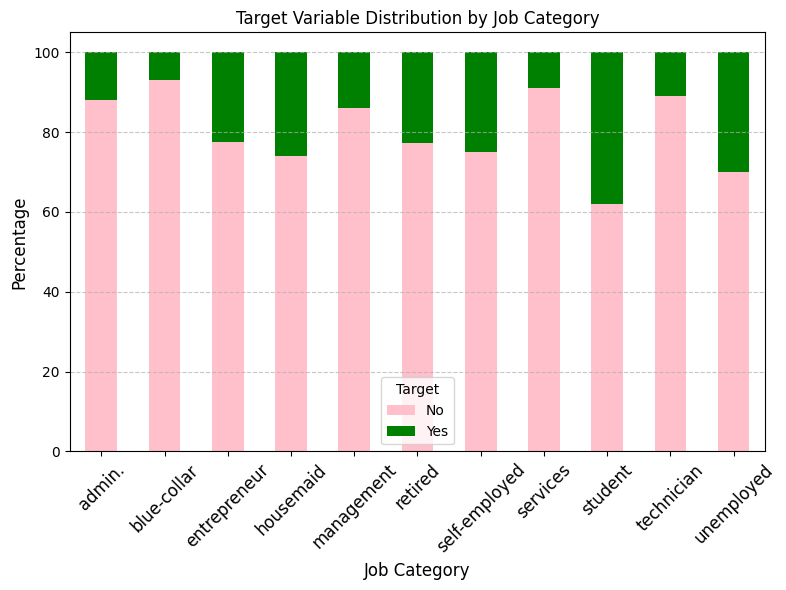

In [17]:
# Investigate the target variable distribution within each job category
# Create a crosstab to analyze target variable distribution across job categories
job_target_dist = pd.crosstab(train_df['job'], train_df['target'], normalize='index') * 100

# Display the crosstab
print(job_target_dist)

# Plot the distribution as a stacked bar chart for better visualization
job_target_dist.plot(kind='bar', stacked=True, figsize=(8, 6), color=['pink', 'green'])

# Add titles and labels
plt.title('Target Variable Distribution by Job Category')
plt.xlabel('Job Category', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Target', labels=['No', 'Yes'])
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

**Insights:**
* Students, housemaids, and unemployed individuals show relatively higher proportions of `yes` (green bar) outcomes, indicating they are more likely to respond positively to the target variable. Focus marketing or outreach efforts on these groups.
* Blue-collar and services job categories have the smallest proportions of `yes` outcomes, suggesting these groups are less likely to respond positively. Consider redesigning strategies for these groups.

   target default housing loan  Count
0      no      no      no   no  11192
1      no      no      no  yes   2179
2      no      no     yes   no  15253
3      no      no     yes  yes   3356
4      no     yes      no   no    356
5      no     yes      no  yes    322
6      no     yes     yes   no    410
7      no     yes     yes  yes    316
8     yes      no      no   no   2697
9     yes      no      no  yes    388
10    yes      no     yes   no   1496
11    yes      no     yes  yes    393
12    yes     yes      no   no    201
13    yes     yes      no  yes    219
14    yes     yes     yes   no    215
15    yes     yes     yes  yes    218




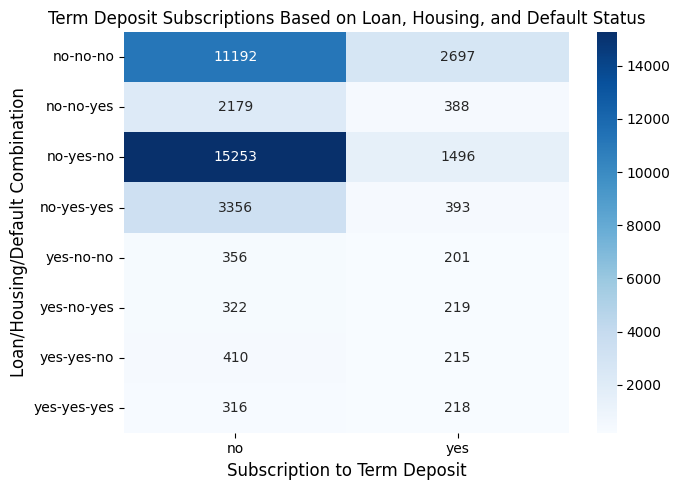

In [18]:
# Term deposit subscriptions based on loan, housing, and default status
count = train_df.groupby(['target','default','housing','loan']).size().reset_index().rename(columns={0: 'Count'})
print(count)
print("\n") 

# Pivot the data to have 'target' as columns, and other features as rows
pivot_table = count.pivot_table(values='Count', index=['default', 'housing', 'loan'], columns='target', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')

# Set plot labels and title
plt.title("Term Deposit Subscriptions Based on Loan, Housing, and Default Status")
plt.ylabel("Loan/Housing/Default Combination", fontsize=12)
plt.xlabel("Subscription to Term Deposit", fontsize=12)

# Show the chart
plt.tight_layout()
plt.show()

**Insights:**

* A majority of combinations across "loan," "housing," and "default" statuses fall under the "no subscription" category.
* The group with no loan, no housing, and no default has the largest count among the "yes" subscription outcomes. This group seems the least burdened by financial obligations and is more likely to subscribe compared to other combinations.
* Individuals who have defaulted ("yes" in the default column) show significantly lower subscription rates to term deposits, indicating that defaults may negatively influence the likelihood of subscription. Any combination involving a default has the least likelihood of subscribing to term deposits.

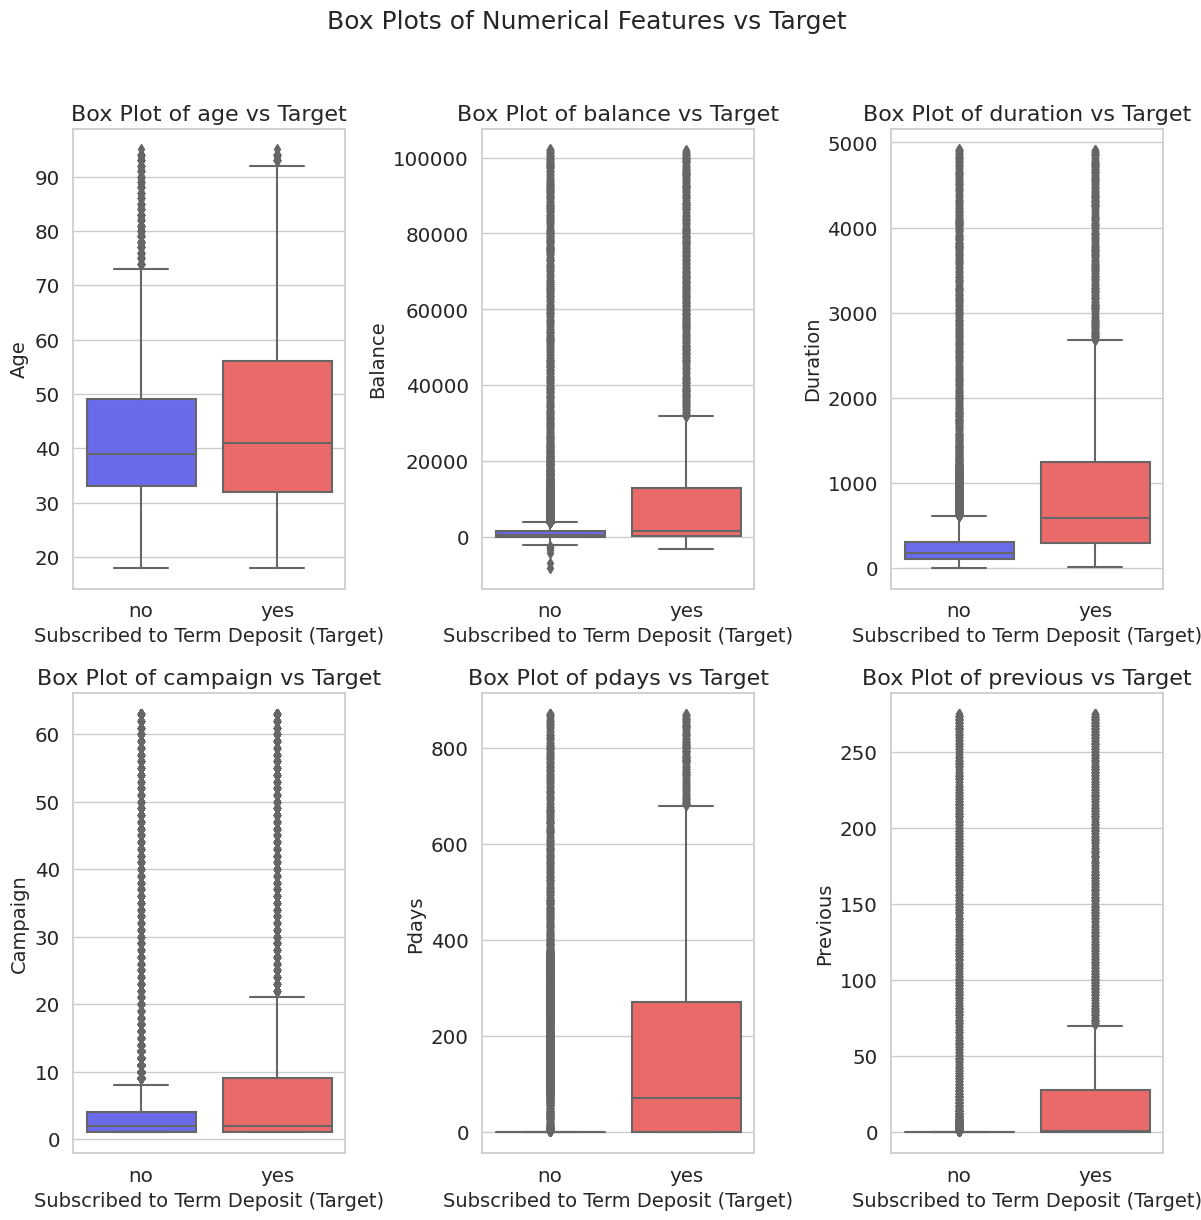

In [19]:
# Numerical Features vs Target
# Set the Seaborn style and font size globally
sns.set(style="whitegrid", font_scale=1.3)

# Set the figure size for better visibility
plt.figure(figsize=(12, 12))

# Create a box plot for each feature in the 'num_cols' list
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='target', y=col, data=train_df, palette='seismic')
    
    # Set title and labels with increased font size
    plt.title(f'Box Plot of {col} vs Target', fontsize=16)
    plt.xlabel('Subscribed to Term Deposit (Target)', fontsize=14)
    plt.ylabel(f'{col.capitalize()}', fontsize=14)

# Add a centralized heading for all subplots
plt.suptitle("Box Plots of Numerical Features vs Target", fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

**Insights:**
1. Age: Customers who subscribed to term deposits ("yes") tend to have a slightly higher median age compared to those who did not ("no").
2. Balance: Outliers exist in both ("yes") and ("no") groups, with some very high balances, suggesting the need for capping or further exploration.
3. Duration: Subscribed customers have much higher call durations, as evidenced by their higher median and interquartile range (IQR). This aligns with the intuition that longer calls might correlate with successful term deposit subscriptions.
4. Campaign: Outliers show some customers were contacted many times without subscribing, suggesting potential diminishing returns from excessive contacts. Reduce the number of excessive contacts ("campaign") and focus on recent and repeated contacts ("previous" and "pdays") for better outcomes.

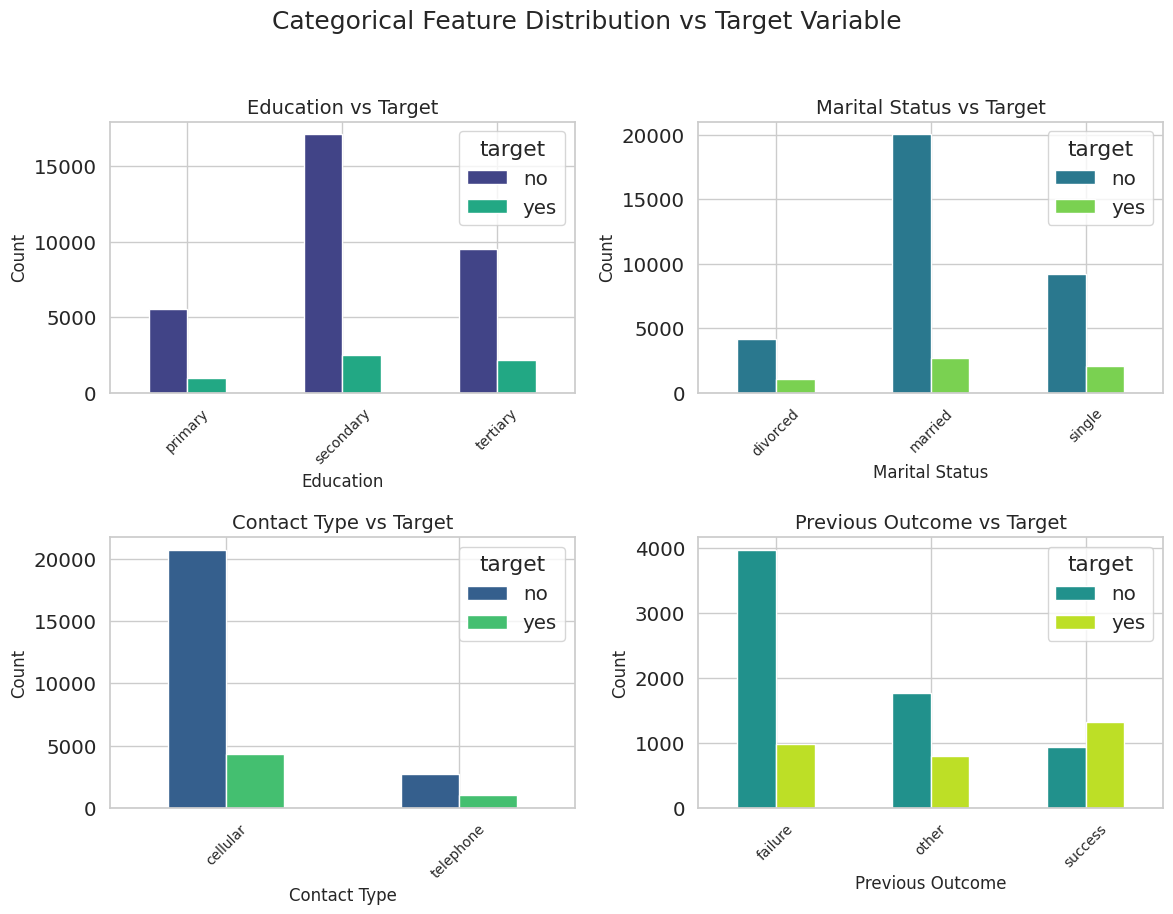

In [20]:
# Understanding categorical feature distribution
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Define the viridis color palette
colors = sns.color_palette("viridis", as_cmap=True)

# Crosstab for 'education' vs. 'target'
pd.crosstab(train_df['education'], train_df['target']).plot(kind='bar', ax=axes[0, 0], color=colors([0.2, 0.6]))
axes[0, 0].set_title('Education vs Target', fontsize=14)
axes[0, 0].set_xlabel('Education', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10)

# Crosstab for 'marital' vs. 'target'
pd.crosstab(train_df['marital'], train_df['target']).plot(kind='bar', ax=axes[0, 1], color=colors([0.4, 0.8]))
axes[0, 1].set_title('Marital Status vs Target', fontsize=14)
axes[0, 1].set_xlabel('Marital Status', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10)

# Crosstab for 'contact' vs. 'target'
pd.crosstab(train_df['contact'], train_df['target']).plot(kind='bar', ax=axes[1, 0], color=colors([0.3, 0.7]))
axes[1, 0].set_title('Contact Type vs Target', fontsize=14)
axes[1, 0].set_xlabel('Contact Type', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)

# Crosstab for 'poutcome' vs. 'target'
pd.crosstab(train_df['poutcome'], train_df['target']).plot(kind='bar', ax=axes[1, 1], color=colors([0.5, 0.9]))
axes[1, 1].set_title('Previous Outcome vs Target', fontsize=14)
axes[1, 1].set_xlabel('Previous Outcome', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)

# Add a centralized heading for all subplots
plt.suptitle("Categorical Feature Distribution vs Target Variable", fontsize=18, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Insights:**

1. Education vs Target:
    * Clients with tertiary education have a higher proportion of positive responses (yes) compared to those with primary education.
    * Secondary education represents the largest group, but its conversion rate (yes) is lower than tertiary education.

2. Marital Status vs Target:
    * Married clients form the largest group, but their positive response rate is relatively low.
    * Single clients exhibit a higher conversion rate (yes) compared to divorced or married clients.

3. Contact Type vs Target:
    * Cellular contact is significantly more effective in generating positive responses (yes) compared to telephone contact.
    * The majority of negative responses (no) come from cellular contact due to its higher usage overall.

4. Previous Outcome vs Target:
    * A previous outcome of success has the highest positive response rate (yes), indicating strong influence. Similarly, clients with a failure in previous outcomes show a much lower likelihood of subscribing, suggesting negative historical bias.


In [21]:
print(train_df['campaign'].min())
print(train_df['campaign'].max())

1
63


## 7. Feature Engineering and Data Preprocessing

In [22]:
# Feature Engineering Function
def feature_engineering(df):
    # 1. Binning 'campaign' into categories (low, medium, high)
    campaign_bins = [-1, 2, 5, df['campaign'].max()]  # Define bins
    df['campaign_bins'] = pd.cut(df['campaign'], bins=campaign_bins, labels=['low', 'medium', 'high'], include_lowest=True)
    
    # 2. Binning 'previous' into categories (low, medium, high)
    previous_bins = [-1, 1, 3, df['previous'].max()]  # Define bins
    df['previous_bins'] = pd.cut(df['previous'], bins=previous_bins, labels=['low', 'medium', 'high'], include_lowest=True)
    
    # 3. Interaction Term: 'duration / (campaign + 1)'
    df['duration_campaign_interaction'] = df['duration'] / (df['campaign'] + 1)  # Add 1 to avoid division by zero

    # 4. Interaction Term: 'duration * log(previous + 1)'
    df['duration_previous_interaction'] = df['duration'] * np.log1p(df['previous'])  # Log transformation for scaling

    # 5. Interaction Term: 'duration + campaign + previous'
    df['combined_interaction'] = df['duration'] + df['campaign'] + df['previous']

    # 6. Square Root Transformation for 'duration'
    df['duration_sqrt'] = np.sqrt(df['duration'])

    # 7. Normalize All Interaction Features for Consistency
    scaler = StandardScaler()
    interaction_features = ['duration_campaign_interaction', 'duration_previous_interaction', 'combined_interaction']
    df[interaction_features] = scaler.fit_transform(df[interaction_features])
    
    # 8. Drop Original Columns to Reduce Redundancy (Optional)
    # Uncomment below to drop these columns
    # df = df.drop(columns=['campaign', 'previous', 'duration'], errors='ignore')
    
    return df

In [23]:
# Apply Feature Engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

In [24]:
# Define numeric and categorical columns
numeric_features = num_cols  
categorical_features = cat_cols 

# Define preprocessing for numeric features
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer(random_state=42)), 
    ('scaler', StandardScaler()), 
    ('outlier_capping', FunctionTransformer(  
        lambda x: np.clip(
            x,
            np.quantile(x, 0.01, axis=0),
            np.quantile(x, 0.99, axis=0),
        ),
        validate=False  # To ensure it processes properly
    ))
])


# Define preprocessing for categorical features
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [25]:
# Preprocess function for train and test
def preprocess_data(df, is_train=True):
    # Drop 'last contact date'
    df = df.drop(columns=['last contact date'], errors='ignore')
    
    # Apply preprocessor for numeric and categorical columns
    if is_train:
        transformed = preprocessor.fit_transform(df)
    else:
        transformed = preprocessor.transform(df)
    
    # Return transformed data
    return transformed

In [26]:
# Define target variable and preprocess the data
X = train_df.drop(columns=['target'])  # Extract features from train_df
y = train_df['target'].apply(lambda x: 1 if x == 'yes' else 0)  # Encode target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing to training and validation sets
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val, is_train=False)
test_df = preprocess_data(test_df, is_train=False)

In [27]:
print(type(X_train))

<class 'numpy.ndarray'>


### Understanding the Imbalance and Scattered Nature of the Dataset

### A. Check for Noise in the Minority Class

Class Distribution:
 target
0    33384
1     5827
Name: count, dtype: int64


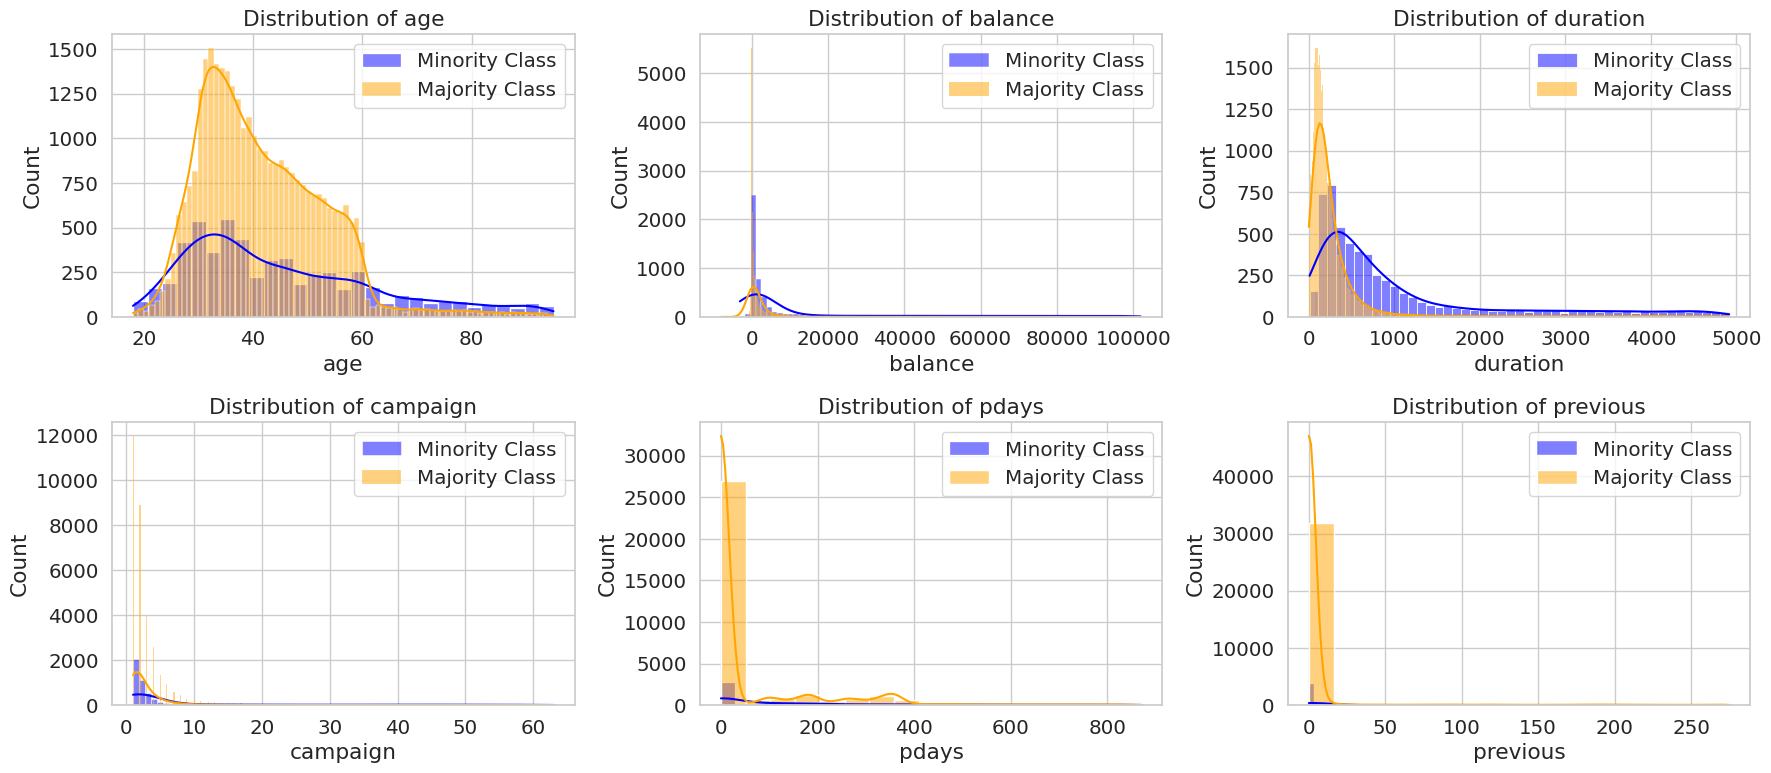

In [28]:
# Count the number of samples in each class
class_counts = y.value_counts()
print("Class Distribution:\n", class_counts)

# Check minority class distribution in numeric features
minority_class = X[y == 1]  
majority_class = X[y == 0]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))  # Create a 2x3 grid for subplots

for idx, col in enumerate(num_cols):
    ax = axes[idx // 3, idx % 3]  # Determine the position in the grid
    sns.histplot(minority_class[col], kde=True, color='blue', label='Minority Class', ax=ax)
    sns.histplot(majority_class[col], kde=True, color='orange', label='Majority Class', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Look for overlaps or outliers in the distributions

**Observations:** Potential noise or inconsistencies in the minority class as the distributions for numeric features in the minority class do not overlap significantly with the majority class.

**Insights:**
1. Age Distribution:    * The majority class has a clear peak around ages 30–40, with a gradual decline for older individuals.
    * The minority class also follows a similar trend, but there are sporadic counts for individuals in the older age range (e.g., 70–90 years). These outliers may represent noise, as the minority class counts are low in these age ranges.
2. Balance Distribution:
    * The majority class shows a heavy concentration of individuals with low balances, tapering off gradually with higher balances.
    * The minority class has significant overlaps with the majority class for lower balances but exhibits scattered high-balance instances. These high-balance outliers could indicate noise.
3. Duration Distribution:
    * The majority class demonstrates a highly skewed distribution, with most call durations concentrated around shorter durations (e.g., <300 seconds).
    * The minority class shows longer durations for some calls (>4000 seconds). These longer calls, which deviate significantly from the majority pattern, may require closer inspection for relevance or noise.
4. Campaign Distribution:
    * The majority class has a steep decline after 5–10 contact attempts, while the minority class has sporadic entries for higher contact counts (e.g., >30). These high contact counts for the minority class may represent noisy or less reliable data points.
5. Previous Distribution:    * Most values are concentrated around 0–2 for both classes, indicating very few prior contacts.
    * For the minority class, there are occasional instances of higher "previous" values. These may be noisy data points if they do not align with expected customer behaviors.



### B. Check if the Minority Class is Underrepresented

In [29]:
# Calculate class imbalance ratio
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")

# Threshold: If imbalance ratio < 0.1, the minority class is underrepresented
if imbalance_ratio < 0.1:
    print("The minority class is highly underrepresented.")
else:
    print("The minority class is not severely underrepresented.")

Class Imbalance Ratio: 0.17
The minority class is not severely underrepresented.


### C. Assess Diversity or Scattered Nature of the Minority Class

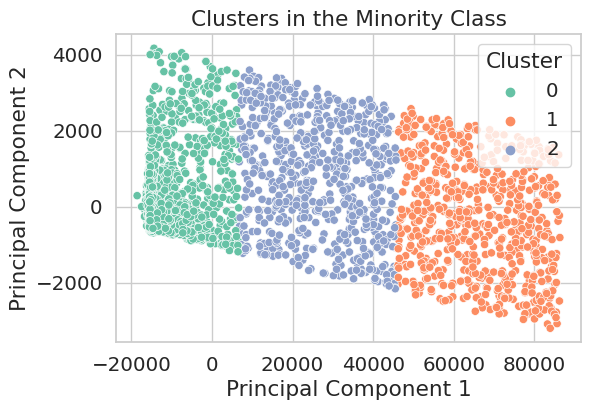

Cluster Sizes:
 0    4546
1     658
2     623
Name: count, dtype: int64


In [30]:
# Ensure that minority_class contains only numeric columns
minority_class_numeric = minority_class.select_dtypes(include=['number'])

# Reduce dimensions to visualize clusters
pca = PCA(n_components=2)
minority_class_pca = pca.fit_transform(minority_class_numeric)

# Perform clustering on minority class
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(minority_class_pca)

# Visualize clusters
plt.figure(figsize=(6, 4))
sns.scatterplot(x=minority_class_pca[:, 0], y=minority_class_pca[:, 1], hue=clusters, palette='Set2')
plt.title('Clusters in the Minority Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Calculate cluster sizes
cluster_sizes = pd.Series(clusters).value_counts()
print("Cluster Sizes:\n", cluster_sizes)

**Observations:**
Minority class is not entirely diverse

**Insights:**
* The minority class data points are grouped into three clusters of varying sizes. This shows that the minority class is not uniform and has distinct subgroups.
* The clusters are clearly separable in the reduced 2D PCA space, suggesting that the minority class is **not highly scattered.**
* Clusters 1 and 2 are compact, indicating homogeneity within these subgroups, while Cluster 0 is larger and slightly more dispersed.

### Preprocessing and Balancing with ADASYN

In [31]:
# Apply ADASYN to the training set only
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# # Check class distribution before and after applying ADASYN
print(f"Original Class Distribution: {Counter(y_train)}")
print(f"Class Distribution after ADASYN: {Counter(y_train_adasyn)}")

Original Class Distribution: Counter({0: 26707, 1: 4661})
Class Distribution after ADASYN: Counter({1: 27738, 0: 26707})


## 8. Model Building and Evaluation

### Model Choice
Given the distribution patterns, **tree-based models** (e.g., LightGBM, XGBoost) may handle these outliers better than linear models, as they are less sensitive to extreme values and skewed distributions.

### Models for training the dataset:
1. Random Forest
2. XGBoost
3. LightGBM
4. Gradient Boosting


### 1. Define Models and Stratified K-Fold

In [32]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage
        max_depth=3,  # Maximum depth of individual trees
        random_state=42  
    )
}

# Define Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 2. Model Training and Cross-Validation

In [33]:
# Initialize an empty dictionary to store cross-validation results
cv_results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    fold_f1_scores = []
    
    for train_index, val_index in kf.split(X_train_adasyn, y_train_adasyn):
        # Split data for the current fold
        X_fold_train, X_fold_val = X_train_adasyn[train_index], X_train_adasyn[val_index]
        y_fold_train, y_fold_val = y_train_adasyn.iloc[train_index], y_train_adasyn.iloc[val_index]
        
        # Train the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict and evaluate
        y_fold_pred = model.predict(X_fold_val)
        fold_f1 = f1_score(y_fold_val, y_fold_pred, average='macro')
        fold_f1_scores.append(fold_f1)
    
    # Store cross-validation results
    mean_f1 = np.mean(fold_f1_scores)
    cv_results[model_name] = mean_f1
    print(f"Mean F1 Macro Score for {model_name}: {mean_f1:.4f}")


Training Random Forest...
Mean F1 Macro Score for Random Forest: 0.9176

Training XGBoost...
Mean F1 Macro Score for XGBoost: 0.9102

Training LightGBM...
[LightGBM] [Info] Number of positive: 22191, number of negative: 21365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6900
[LightGBM] [Info] Number of data points in the train set: 43556, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509482 -> initscore=0.037933
[LightGBM] [Info] Start training from score 0.037933
[LightGBM] [Info] Number of positive: 22191, number of negative: 21365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

### 3. Model Evaluation Before Hyperparameter Tuning

In [34]:
# Evaluate models on the hold-out validation set
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on Validation Set...")
    
    # Predict and calculate F1 score
    y_val_pred = model.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred, average='macro')
    print(f"F1 Macro Score on Validation Set for {model_name}: {f1_val:.4f}")
    
    # Classification Report
    print(f"Classification Report for {model_name}:\n{classification_report(y_val, y_val_pred)}")


Evaluating Random Forest on Validation Set...
F1 Macro Score on Validation Set for Random Forest: 0.7360
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6677
           1       0.49      0.66      0.56      1166

    accuracy                           0.85      7843
   macro avg       0.71      0.77      0.74      7843
weighted avg       0.87      0.85      0.86      7843


Evaluating XGBoost on Validation Set...
F1 Macro Score on Validation Set for XGBoost: 0.7336
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6677
           1       0.52      0.58      0.55      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.74      0.73      7843
weighted avg       0.87      0.86      0.86      7843


Evaluating LightGBM on Validation Set...
F1 Macro Score on Validation

### Random Forest Tuning

In [35]:
# # Define the parameter grid for Random Forest
# rf_param_grid = {
#     'n_estimators': [490, 495, 500],  # Number of trees
#     'max_depth': [20, 25, 30],  # Maximum tree depth to prevent overfitting
#     'min_samples_split': [12, 16, 20],  # Minimum samples to split
#     'min_samples_leaf': [1, 2],  # Minimum samples at a leaf node
#     'max_features': ['log2']  # Number of features for splitting at each node  
# }

# # RandomizedSearchCV for Random Forest
# rf = RandomForestClassifier(random_state=42)
# rf_random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit to the training data
# rf_random_search.fit(X_train_adasyn, y_train_adasyn)

# # Best parameters
# best_rf = rf_random_search.best_estimator_
# print(f"Best parameters for Random Forest: {rf_random_search.best_params_}")

### XGBoost Tuning

In [36]:
# # Define parameter grid for XGBoost
# xgb_param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of boosting rounds
#     'max_depth': [12, 14, 16],  # Maximum tree depth
#     'learning_rate': [0.03, 0.04, 0.05],  # Smaller learning rate for better generalization
#     'colsample_bytree': [0.5, 0.6, 0.7],  # Features randomly selected for each tree, use around 50%
#     'subsample': [0.5, 0.52, 0.54],  # Samples randomly selected for each tree, use around 50%
#     'reg_alpha': [7.1, 7.3, 7.5],  # L1
#     'reg_lambda': [0.6, 0.8, 1.0]  # L2
# }

# # Initialize XGBoost model
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Initialize RandomizedSearchCV for XGBoost
# xgb_random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=xgb_param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV with early stopping
# xgb_random_search.fit(
#     X_train_adasyn, y_train_adasyn,
#     eval_set=[(X_val, y_val)],
#     early_stopping_rounds=50,
#     verbose=False
# )

# # Best parameters for XGBoost
# best_xgb_params = xgb_random_search.best_params_
# print(f"Best parameters for XGBoost: {best_xgb_params}")

### LightGBM Tuning

In [37]:
# # Define parameter grid for LightGBM
# lgbm_param_grid = {
#     'num_leaves': [88, 90, 92],
#     'max_depth': [18, 20, 22],
#     'learning_rate': [0.0071, 0.0073, 0.0075],
#     'n_estimators': [430, 435, 440],
#     'min_child_samples': [24, 26, 28],
#     'subsample': [0.79, 0.8, 0.81],
#     'colsample_bytree': [0.5, 0.52, 0.54],
#     'reg_alpha': [0.00008, 0.0001, 0.00012],
#     'reg_lambda': [0.0001, 0.00012, 0.00014],
# }

# # Initialize LightGBM model with callbacks
# lgbm = lgb.LGBMClassifier(
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1  # Suppress logs from LightGBM
# )

# # Initialize RandomizedSearchCV for LightGBM
# lgbm_random_search = RandomizedSearchCV(
#     estimator=lgbm,
#     param_distributions=lgbm_param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV with early stopping
# lgbm_random_search.fit(
#     X_train_adasyn, y_train_adasyn,
#     eval_set=[(X_val, y_val)],
#     eval_metric='f1',
#     callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)]
# )

# # Best parameters for LightGBM
# best_lgbm_params = lgbm_random_search.best_params_
# print(f"Best parameters for LightGBM: {best_lgbm_params}")

### Training the Top 3 Models with the Best Parameters

* Best parameters for Random Forest: {'n_estimators': 495, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
* Best parameters for XGBoost: {'subsample': 0.52, 'reg_lambda': 0.6, 'reg_alpha': 7.3, 'n_estimators': 300, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
* Best parameters for LightGBM: {'subsample': 0.81, 'reg_lambda': 0.0001, 'reg_alpha': 0.0001, 'num_leaves': 92, 'n_estimators': 440, 'min_child_samples': 24, 'max_depth': 22, 'learning_rate': 0.0071, 'colsample_bytree': 0.5}

In [38]:
X_train_adasyn.shape

(54445, 30)

In [39]:
# Feature Selection
select_k = SelectKBest(mutual_info_classif, k=10)

# Apply feature selection to training, validation, and test sets
X_train_adasyn_selected = select_k.fit_transform(X_train_adasyn, y_train_adasyn)
X_val_selected = select_k.transform(X_val)
X_test_selected = select_k.transform(test_df)

In [40]:
# Define the tuned hyperparameters
rf_params = {
    'n_estimators': 493,
    'max_depth': 27,
    'min_samples_split': 16,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'random_state': 42
}

xgb_params = {
    'n_estimators' : 214,
    'max_depth' : 14,
    'learning_rate' : 0.0381,
    'subsample' : 0.54,
    'colsample_bytree' : 0.563,
    'reg_alpha' : 7.359,
    'reg_lambda' : 0.833,
    'random_state' : 42,
    'use_label_encoder' : False,
    'eval_metric' : 'logloss'
}

lgb_params = {
    'num_leaves': 90,
    'max_depth': 20,
    'learning_rate': 0.0073,
    'n_estimators': 435,
    'min_child_samples': 26,
    'subsample': 0.802,
    'colsample_bytree': 0.527,
    'reg_alpha': 0.0001,
    'reg_lambda': 0.0001,
    'random_state': 42
}

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(**rf_params),
    "XGBoost": xgb.XGBClassifier(**xgb_params),
    "LightGBM": lgb.LGBMClassifier(**lgb_params)
}

In [41]:
# # Define F1 Macro Scorer
# f1_macro_scorer = make_scorer(f1_score, average='macro')

# # Stratified K-Fold Cross-Validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize Results Dictionary
# rfe_results = {}

# for model_name, model in models.items():
#     print(f"\nPerforming RFE with CV for {model_name}...")
    
#     # Perform Recursive Feature Elimination with Cross-Validation
#     rfecv = RFECV(
#         estimator=model,
#         step=1,
#         cv=cv,
#         scoring=f1_macro_scorer,
#         n_jobs=-1  # Parallelize computation
#     )
    
#     # Fit RFECV
#     rfecv.fit(X_train_adasyn, y_train_adasyn)
    
#     # Store the results
#     rfe_results[model_name] = {
#         "optimal_features": rfecv.n_features_,
#         "ranking": rfecv.ranking_,
#         "cv_score": rfecv.cv_results_['mean_test_score'],
#         "support_mask": rfecv.support_,
#         "estimator": rfecv.estimator_
#     }
    
#     print(f"{model_name} Optimal Number of Features: {rfecv.n_features_}")
#     print(f"Cross-Validation F1 Macro Score: {np.mean(rfecv.cv_results_['mean_test_score']):.4f}")

In [42]:
# # Important rfe results
# print("rfecv.n_features_: ", rfecv.n_features_)
# print("rfecv.estimator_: ", rfecv.estimator_)

In [43]:
# # Evaluate the best-performing model using the optimal features
# for model_name, result in rfe_results.items():
#     print(f"\nEvaluating {model_name} on the validation set...")

#     # Retrieve the selected feature indices (mask)
#     selected_feature_indices = result["support_mask"]
    
#     # Select features from training and validation sets
#     X_train_selected = X_train_adasyn[:, selected_feature_indices]
#     X_val_selected = X_val[:, selected_feature_indices]
    
#     # Get the trained model from RFECV
#     model = result["estimator"]
    
#     # Predict on the validation set
#     y_val_pred = model.predict(X_val_selected)
    
#     # Calculate F1 Score
#     f1_macro = f1_score(y_val, y_val_pred, average='macro')
#     print(f"F1 Macro Score for {model_name} on Validation Set: {f1_macro:.4f}")
    
#     # Generate a classification report
#     print(f"Classification Report for {model_name}:\n")
#     print(classification_report(y_val, y_val_pred))

### Best LightGBM Model for Score Cut-off Submission

In [44]:
# # Select features from training and validation sets
# X_train_selected = X_train_adasyn[:, rfe_results["LightGBM"]["support_mask"]]
# X_val_selected = X_val[:, rfe_results["LightGBM"]["support_mask"]]

# Define the tuned hyperparameters
best_params = {
    'num_leaves': 90,
    'max_depth': 20,
    'learning_rate': 0.0073,
    'n_estimators': 435,
    'min_child_samples': 26,
    'subsample': 0.80,
    'colsample_bytree': 0.52,
    'reg_alpha': 0.0001,
    'reg_lambda': 0.0001,
    'random_state': 42  # Always include this for reproducibility
}

# Initialize the LightGBM model with tuned parameters
lgbm_model = lgb.LGBMClassifier(**best_params)

# Fit the model with early stopping on the reduced training and validation data
lgbm_model.fit(
    X_train_adasyn_selected, y_train_adasyn,
    # X_train_selected, y_train_adasyn,
    eval_set=[(X_val_selected, y_val)],  # Validation set for early stopping
    eval_metric='f1',  # Use F1 as the evaluation metric
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(50)]
)

# Make predictions on the validation set
y_val_pred_lgbm = lgbm_model.predict(X_val_selected)

# Calculate F1 Macro Score
f1_lgbm = f1_score(y_val, y_val_pred_lgbm, average='macro')
print(f"LightGBM F1 Macro Score = {f1_lgbm:.4f}")

# Generate classification report for more details  
classification_rep_lgbm = classification_report(y_val, y_val_pred_lgbm)
print("Classification Report:")
print(classification_rep_lgbm)

[LightGBM] [Info] Number of positive: 27738, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 54445, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509468 -> initscore=0.037878
[LightGBM] [Info] Start training from score 0.037878
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.581827
[100]	valid_0's binary_logloss: 0.499531
[150]	valid_0's binary_logloss: 0.446834
[200]	valid_0's binary_logloss: 0.410871
[250]	valid_0's binary_logloss: 0.382468
[300]	valid_0's binary_logloss: 0.36184
[350]	valid_0's binary_logloss: 0.346881
[400]	valid_0's binary_logloss: 0.334943
Did not meet early stopping. Best iteration is:
[435]	va

### Submission File

In [45]:
# Create Submission File for Test Set
# Make predictions on the test set

# # Use the best model for test predictions
# best_model_name = "LightGBM" 
# best_model = rfe_results[best_model_name]["estimator"]

# # Select features for the test set
# X_test_selected = test_df[:, rfe_results["LightGBM"]["support_mask"]]

# # Make predictions on the test set
# test_preds = best_model.predict(X_test_selected)
test_preds = lgbm_model.predict(X_test_selected)

# Create submission file
submission = pd.DataFrame({
    'id': range(len(test_preds)),  # Sequential IDs
    'target': test_preds
})

# Replace 0 and 1 back with 'no' and 'yes'
submission['target'] = submission['target'].apply(lambda x: 'yes' if x == 1 else 'no')

# Save submission to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


## 9. Comparison of Models

### Before Hyperparameter Tuning

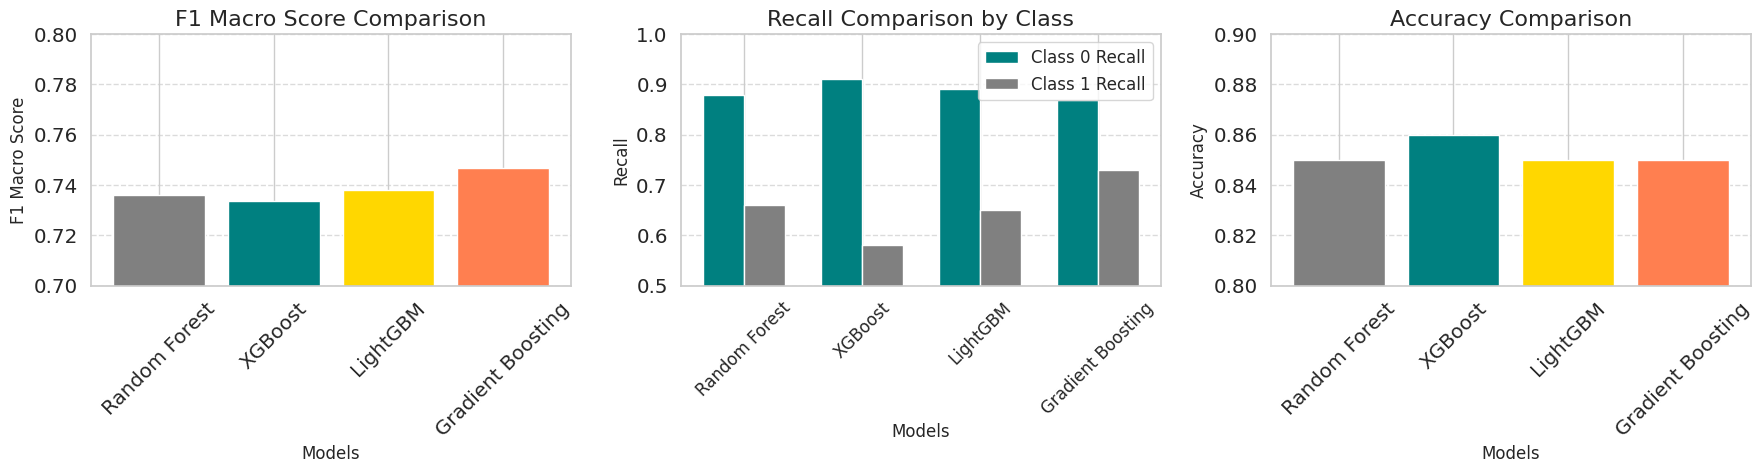

In [46]:
# Data for the charts
models = ["Random Forest", "XGBoost", "LightGBM", "Gradient Boosting"]
f1_scores = [0.7360, 0.7336, 0.7382, 0.7469]
accuracy_scores = [0.85, 0.86, 0.85, 0.85]
recall_0 = [0.88, 0.91, 0.89, 0.87]  # Recall for class 0
recall_1 = [0.66, 0.58, 0.65, 0.73]  # Recall for class 1

# Subplots with 3 charts in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Macro Score Comparison
axes[0].bar(models, f1_scores, color=['grey', 'teal', 'gold', 'coral'])
axes[0].set_title('F1 Macro Score Comparison', fontsize=16)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylim(0.7, 0.8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=45)

# Recall Comparison (Class 0 vs Class 1)
x = np.arange(len(models))  # Position of bars
width = 0.35  # Width of the bars
axes[1].bar(x - width/2, recall_0, width, label='Class 0 Recall', color='teal')
axes[1].bar(x + width/2, recall_1, width, label='Class 1 Recall', color='grey')
axes[1].set_title('Recall Comparison by Class', fontsize=16)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, fontsize=12, rotation=45)
axes[1].legend(fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_ylim(0.5, 1)

# Accuracy Comparison
axes[2].bar(models, accuracy_scores, color=['grey', 'teal', 'gold', 'coral'])
axes[2].set_title('Accuracy Comparison', fontsize=16)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_xlabel('Models', fontsize=12)
axes[2].set_ylim(0.8, 0.9)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

**Insights:**
* While Gradient Boosting shows better performance overall, the gap between Class 0 and Class 1 recall suggests all models could benefit from optimization.
* Class 0 Recall (majority class) is consistently high across all models, with XGBoost having the highest recall for this class.
* Gradient Boosting achieves the best Class 1 recall, suggesting it handles the minority class better.
* XGBoost underperforms for Class 1 recall, showing room for improvement in identifying the minority class.
* All models have similar accuracy, around 85%-86%. Accuracy is not a good standalone metric in imbalanced datasets as it reflects dominance by the majority class.

### After Hyperparameter Tuning and RFECV

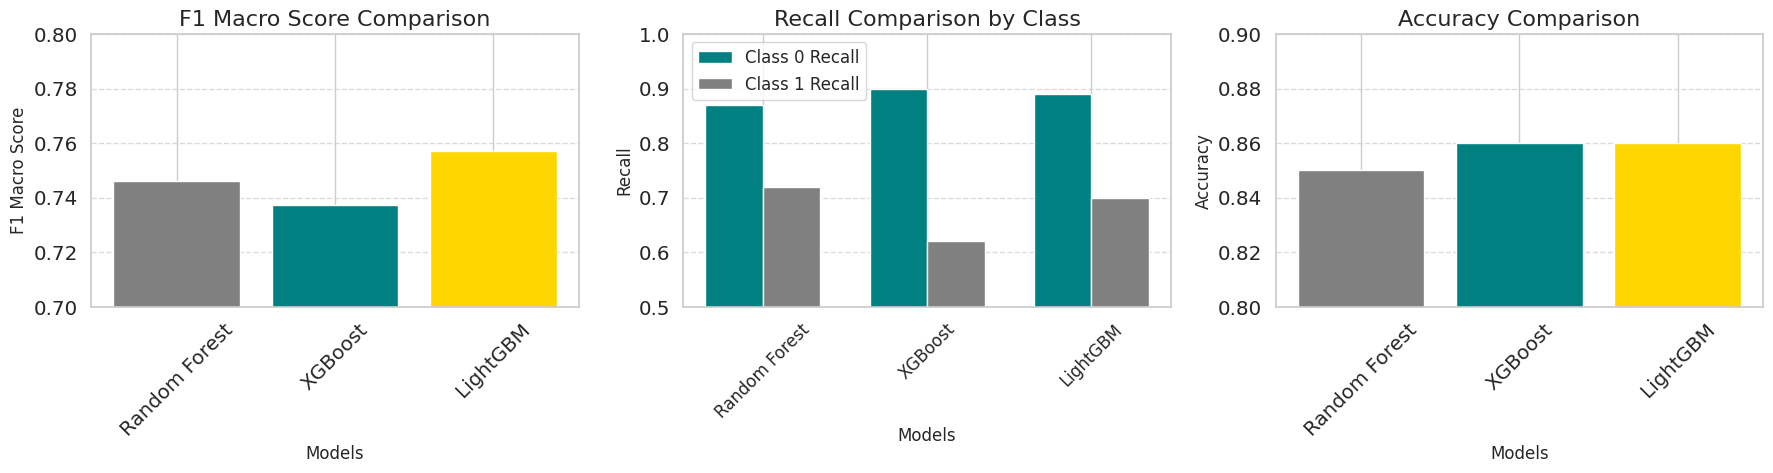

In [47]:
# Data for the charts
models = ["Random Forest", "XGBoost", "LightGBM"]
f1_scores = [0.7460, 0.7374, 0.7573]
accuracy_scores = [0.85, 0.86, 0.86]
recall_0 = [0.87, 0.90, 0.89]  # Recall for class 0
recall_1 = [0.72, 0.62, 0.70]  # Recall for class 1

# Subplots with 3 charts in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Macro Score Comparison
axes[0].bar(models, f1_scores, color=['grey', 'teal', 'gold', 'coral'])
axes[0].set_title('F1 Macro Score Comparison', fontsize=16)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylim(0.7, 0.8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=45)

# Recall Comparison (Class 0 vs Class 1)
x = np.arange(len(models))  # Position of bars
width = 0.35  # Width of the bars
axes[1].bar(x - width/2, recall_0, width, label='Class 0 Recall', color='teal')
axes[1].bar(x + width/2, recall_1, width, label='Class 1 Recall', color='grey')
axes[1].set_title('Recall Comparison by Class', fontsize=16)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, fontsize=12, rotation=45)
axes[1].legend(fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_ylim(0.5, 1)

# Accuracy Comparison
axes[2].bar(models, accuracy_scores, color=['grey', 'teal', 'gold', 'coral'])
axes[2].set_title('Accuracy Comparison', fontsize=16)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_xlabel('Models', fontsize=12)
axes[2].set_ylim(0.8, 0.9)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

**Insights:**
* LightGBM consistently delivers the best performance across metrics, making it the most effective model for the dataset.
* Random Forest shows balanced performance and is a reliable second-best option.
* XGBoost lags in minority class recall and F1 Macro Score but performs competitively in accuracy.

## 10. Insights and Recommendations

### Key Decisions and Methods Used
* **ADASYN** was chosen over **SMOTE** due to its capability to adaptively synthesize samples by considering the density distribution of minority class neighbors. This leads to a more balanced and meaningful augmentation of the minority class, reducing noise. After applying ADASYN, the class distribution became balanced, improving recall and F1 scores for the minority class.
* **SelectKBest** was utilized to rank features by their importance using mutual_info_classif. This ensures that only the most informative features, directly correlated with the target variable, are used for modeling. **Recursive Feature Elimination (RFE)** was considered but was computationally more intensive and less interpretable in this context.
* **F1 Macro** was prioritized because of the dataset's class imbalance. This metric equally weighs precision and recall for both classes, offering a fair assessment of the model's performance. **Accuracy** was avoided as it could be misleading in imbalanced datasets, where the majority class dominates the predictions.

Why Random Forest, XGBoost, and LightGBM?
These models are ensemble-based and gradient boosting, and excel in handling structured data with imbalanced classes.
* **Random Forest:** Chosen for its robustness and ease of implementation, serving as a baseline.
* **XGBoost and LightGBM:** Advanced boosting algorithms selected for their efficiency and ability to handle imbalanced data.
* **Logistic regression** and simpler models were avoided due to their inability to capture complex interactions in structured datasets.
* **Gradient Boosting** (other implementations) was considered redundant given the capabilities of XGBoost and LightGBM.

Why **Stratified K-Fold**?
Ensures that the class distribution is preserved across all folds, preventing overfitting to certain data splits.

### Summary
1. **EDA and Preprocessing:**
    * Explored class imbalance and feature distributions.
    * Applied ADASYN for dynamic minority class augmentation.
    * Feature engineering and handling missing values ensured a clean and enriched dataset.
2. **Feature Selection:**
    * Used RFECV and SelectKBest to identify the top most informative features, optimizing model performance while reducing noise.
3. **Model Building:**
    * Implemented and tuned Random Forest, XGBoost, and LightGBM models.
    * Stratified K-Fold Cross-Validation ensured robust evaluation.
    * Applied early stopping for boosting models to prevent overfitting.
4. **Evaluation and Insights:**
    * F1 Macro was used as the primary metric, emphasizing balanced performance across classes.
    * LightGBM emerged as the best-performing model with superior recall for the minority class.
5. **Submission Preparation:**
    * Predictions were made on the test set using the top model (LightGBM).
    * Results were transformed and saved for submission.

### Industry Insights
A few suggestions that may lead to actionable strategies in the context of direct marketing for bank products:

1. **Segmented Targeting Based on Job Type:**
   - **Blue-collar Workers**: Since "blue-collar" is the most significant segment, it's likely they are a key market for the bank. However, their financial behaviors and needs may differ from those in "management" or "technician" roles. Blue-collar workers may be more sensitive to interest rates, loan accessibility, and fees. Thus, a product targeting their specific financial challenges—such as **low-interest savings accounts** or **low-fee checking accounts**—could increase conversion rates.
   
   - **Technicians and Management**: These individuals likely have higher income levels and possibly better financial literacy. They might respond well to products like **investment services, premium credit cards, or wealth management services**. A more personalized and information-driven approach for these groups could yield better results.
   
2. **Cross-selling Opportunities Based on Employment Type:**
   - **Entrepreneurs and Self-Employed Individuals**: These groups are often overlooked by traditional marketing strategies. Offering financial products tailored to their needs, such as **business loans, credit lines, or insurance products**, may create new revenue streams. Cross-sell personalized business banking solutions to individuals identified as "entrepreneurs" or "self-employed."
   
   - **Students**: While a smaller segment, targeting students with **long-term products** like student loans or starter savings accounts could establish early relationships, leading to **long-term customer retention**. Banks can create programs that offer special rates for students, fostering loyalty as their financial needs grow post-graduation.

3. **Unemployed Segment—Focus on Short-Term, Trust-Building Products:**
   - The **"unemployed"** segment could indicate individuals facing financial instability, making it less likely for them to subscribe to high-value financial products (like term deposits). Instead, marketing could focus on **trust-building**, offering them easy-to-access products such as **basic checking accounts, overdraft protections, or micro-loans**. This can help build a relationship until their employment situation improves, and they can be upsold to better products.

4. **Retired Customers—Targeting Retirement and Wealth Preservation Products:**
   - For the **"retired"** segment, focus on offering **retirement plans, wealth preservation, and annuities**. They are likely looking for ways to securely manage their wealth. Tailoring marketing messages around **retirement planning** and offering **estate management services** may lead to higher conversion rates among this group.

5. **Re-engagement Campaign for Minor Segments (Housemaid, Services)**:
   - While **housemaids** and individuals in **services** roles represent a smaller segment, they may still have untapped potential. A **re-engagement campaign** with simple financial literacy programs could be effective in nurturing leads from these less represented segments. Offering **micro-savings products** or **prepaid debit cards** could provide financial inclusion and convert these users.
   
6. **Customer Journey and Multi-Touchpoint Campaigns for Students and Retired:**
   - **Students** and **retired** customers may require a **longer customer journey** with multiple touchpoints. For students, early engagement through **educational tools** like budgeting apps or savings challenges might be key to future conversions. For retired individuals, consider **face-to-face consultations** or **personalized online services** that offer trust and security in managing their life savings.
   
7. **Optimize Campaign Timing by Job Type:**
   - For jobs like **blue-collar** and **technician**, which may involve non-standard working hours, ensure marketing campaigns are timed for when they are more likely to respond (outside working hours). Email or phone-based campaigns should target non-working hours or weekends to improve engagement.

8. **Bundle Offers for Multiple Job Types**:
   - Consider offering **bundled financial products** aimed at certain groups. For example, combine **retirement savings plans** with **life insurance** for retired or nearing-retirement individuals, or bundle **checking accounts with micro-loans** for blue-collar workers and self-employed individuals.

9. **Digital Outreach for Technologically-Inclined Jobs (Technicians, Entrepreneurs)**:
   - Individuals working as **technicians** and **entrepreneurs** are likely more tech-savvy and accustomed to using digital tools. Marketing campaigns should emphasize **mobile banking apps**, **automated savings tools**, and **online financial education** programs. Focusing on technology-driven solutions could increase adoption rates within these segments.

10. **Create Personas for Targeted Campaigns**:
   - Build **personas** for key segments based on job type, aligning marketing messages to their financial goals:
     - Persona 1: A blue-collar worker focused on saving for emergencies, responding well to products emphasizing security and low fees.
     - Persona 2: A technician interested in long-term growth, willing to explore investment products and premium services.
     - Persona 3: An entrepreneur needing flexibility in business loans and credit.

**Other Insights:**

1. **Target Customers With Housing Loans**: Customers with housing loans, especially those without defaults, show interest in subscribing to term deposits. This group could be a focus for **savings-related campaigns** and targeted offers on term deposits or investment products.

2. **Customers With Personal Loans Are Less Likely to Subscribe**: Customers with personal loans are less likely to subscribe, likely due to financial constraints. This group may benefit from **debt management solutions** or **flexible savings products** that can accommodate their financial situation.

3. **Customers With Defaults**: Customers with a history of default generally do not subscribe to term deposits. These customers may require **reassurance**, such as products designed for **credit rebuilding** or **secure savings options**, and are less likely to engage with long-term investments.

4. **Combination of Loans**: Customers with both housing and personal loans who subscribed to the term deposit may represent an opportunity to create **higher-risk financial products** that offer flexibility or higher returns. For this group, **structured products** or **flexible saving solutions** might be effective.

5. **Small Segments With Mixed Characteristics**: Customers with defaults but who subscribed may represent **niche opportunities**. These customers might be receptive to specialized products designed for those with a credit default history but who show an interest in financial products.

## 11. Acknowledgements 

I would like to express my sincere gratitude to the Kaggle community for providing a platform that fosters collaboration and learning. 

I extend heartfelt gratitude to the contributors of the dataset and to all Kaggle members who have enriched the platform with their knowledge and creativity. Your contributions serve as a beacon of inspiration and a resource for growth in the field of data science.

Lastly, I wish to thank you, the reader, for taking the time to explore this notebook. Your feedback, thoughts, and suggestions are invaluable and deeply appreciated as they guide the continuous improvement of this work.

Thank you!
